Transformers version: 4.51.1
Using device: cuda
Starting DeepSeek model implementation for suicide detection...
Loading processed datasets...
Attempting to load training data from JSON: processed_data_deepseek/deepseek_training_data.json
- Training data loaded with shape: (6965, 5)
Attempting to load validation data from JSON: processed_data_deepseek/deepseek_validation_data.json
- Validation data loaded with shape: (1493, 5)
Attempting to load test data from JSON: processed_data_deepseek/deepseek_test_data.json
- Test data loaded with shape: (1493, 5)
Training data label distribution:
label
0    4097
1    2868
Name: count, dtype: int64
Validation data label distribution:
label
0    878
1    615
Name: count, dtype: int64
Test data label distribution:
label
0    878
1    615
Name: count, dtype: int64
Loading model deepseek-ai/deepseek-llm-7b-base...


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Loading model (this may take a while)...


config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Model loaded successfully on cuda
Do you want to train the model? This may take a while. (y/n): y
Preparing datasets for training...
Created training dataset with 6965 samples
Created validation dataset with 1493 samples
Starting training...
Training error: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 60.88 MiB is free. Process 28502 has 39.49 GiB memory in use. Of the allocated memory 37.54 GiB is allocated by PyTorch, and 1.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Proceeding with evaluation using the pre-trained model...
Saving model...
Model saved to deepseek_model/final
Evaluating model on test data...
Evaluating on 1493 samples...


100%|██████████| 1493/1493 [16:42<00:00,  1.49it/s]



Evaluation Results:
Accuracy: 0.7388
Precision: 0.7013
Recall: 0.6374
F1 Score: 0.6678
AUC: 0.7236

Confusion Matrix:
[[711 167]
 [223 392]]
Do you want to analyze feature importance? This may take a while. (y/n): y
Analyzing feature importance...


100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


Model implementation complete!
Model and evaluation results saved to deepseek_model/


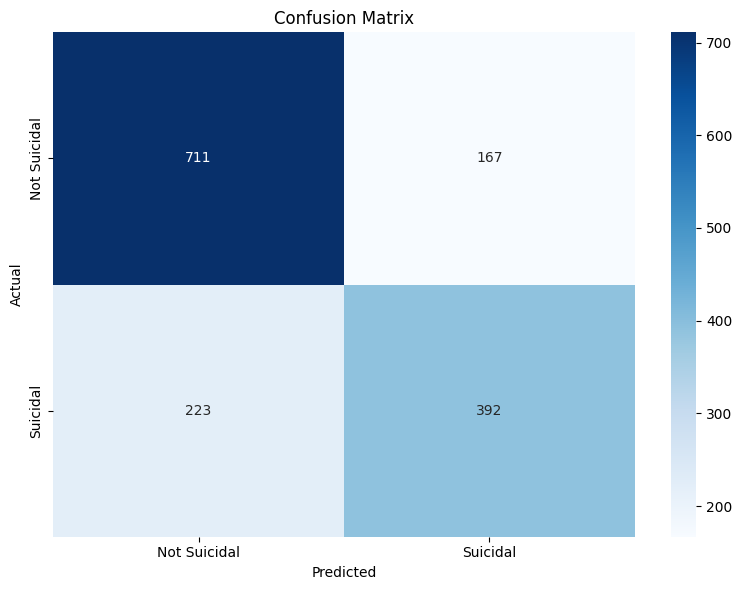

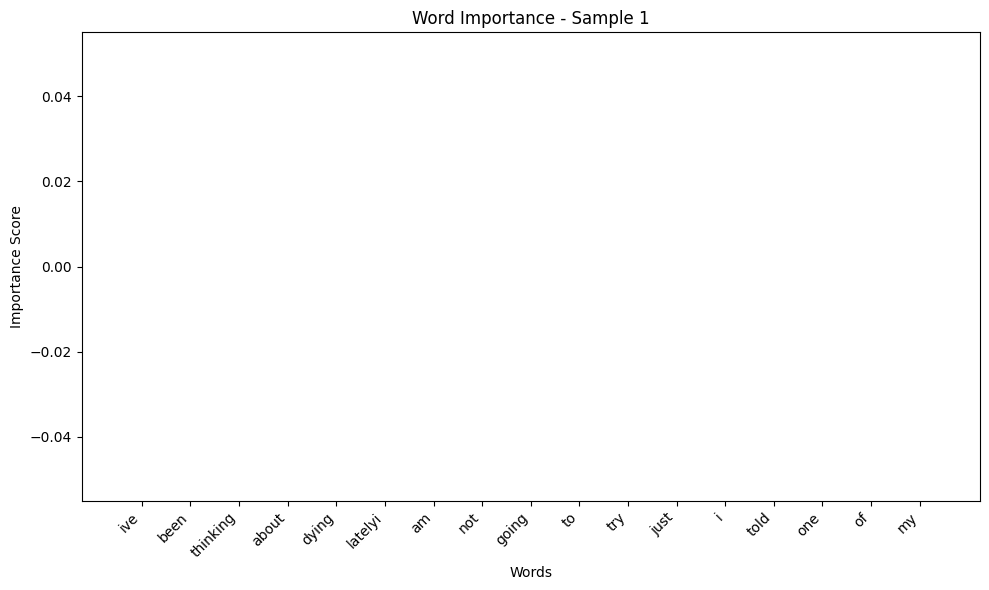

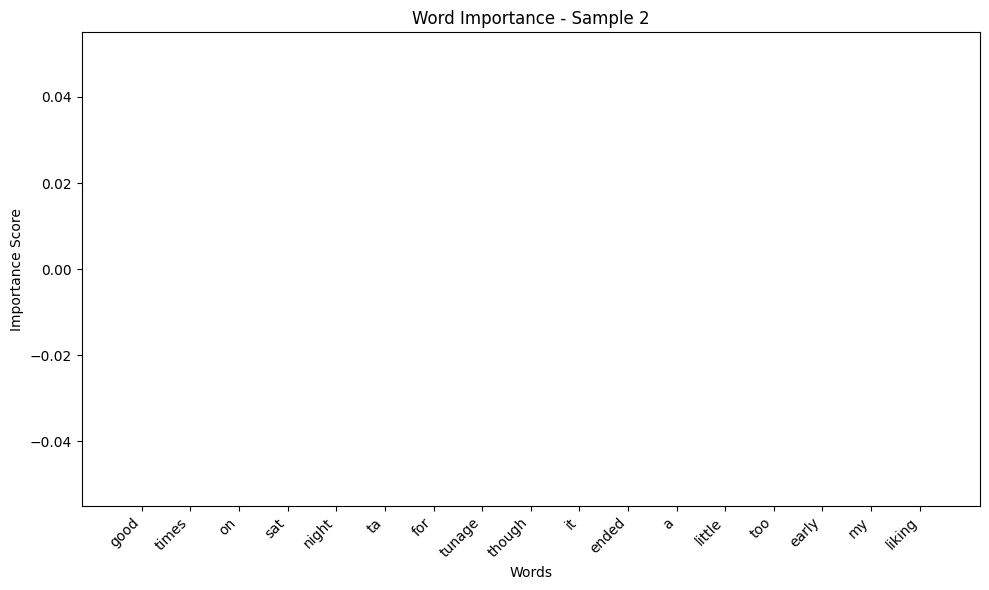

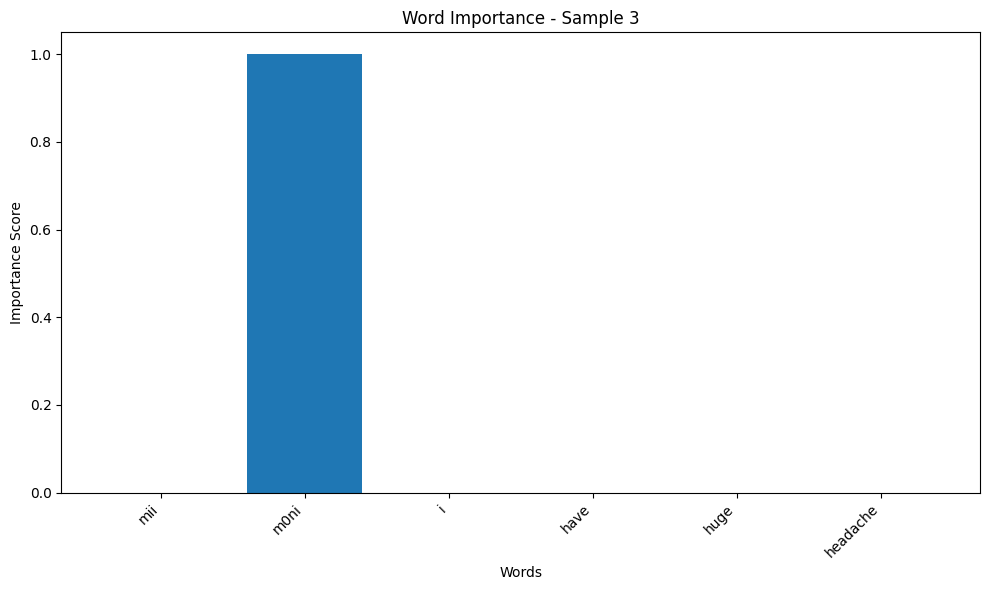

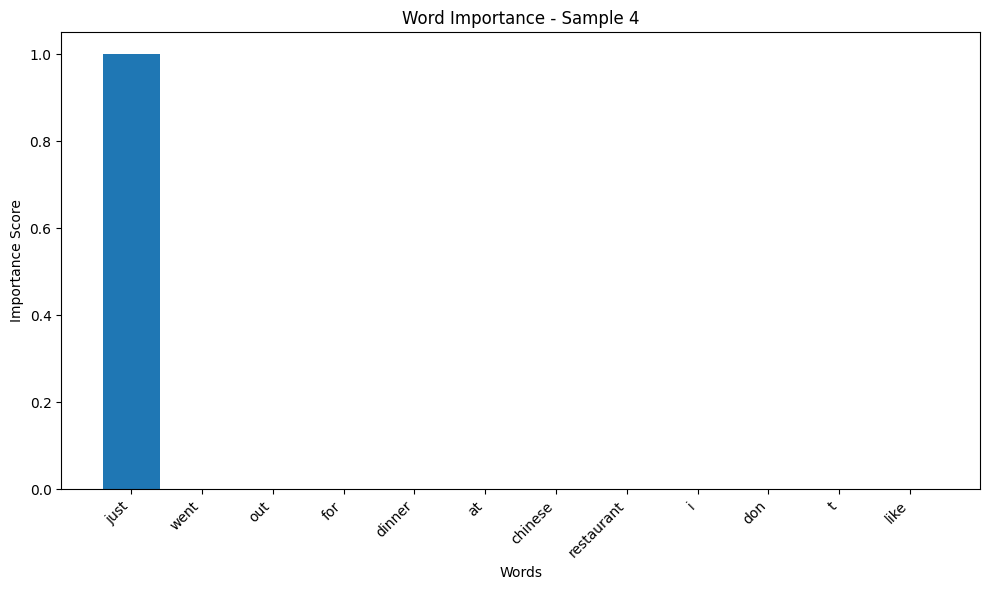

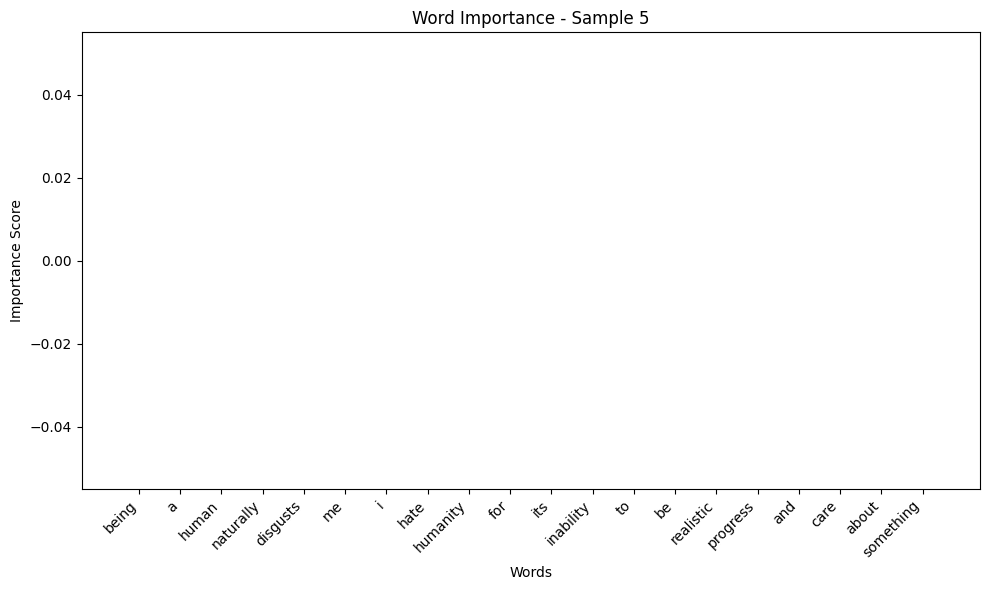

In [2]:
"""
DeepSeek Model Implementation for Suicide Intention Detection
This script implements fine-tuning and inference using the DeepSeek model for suicide detection
With simplified hardware requirements and better error handling
"""
# Run this at the beginning of your notebook
!pip install openpyxl xlrd
import os
import pandas as pd
import numpy as np
import json
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Check transformers version
import transformers
print(f"Transformers version: {transformers.__version__}")

# Suppress warnings
warnings.filterwarnings("ignore")

# Define paths - update this to match your file location
INPUT_DIR = 'processed_data_deepseek'
OUTPUT_DIR = 'deepseek_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# DeepSeek model configuration - using a smaller model for better compatibility
MODEL_NAME = "deepseek-ai/deepseek-llm-7b-base"  # Smaller model than 7b version
MAX_LENGTH = 512
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def load_data():
    """
    Load processed datasets directly from JSON files
    """
    print("Loading processed datasets...")

    try:
        training_json = f"{INPUT_DIR}/deepseek_training_data.json"
        print(f"Attempting to load training data from JSON: {training_json}")
        training_data = pd.read_json(training_json, lines=True)  # Try with lines=True for JSONL format
        if training_data.empty:
            # If empty, try without lines parameter
            training_data = pd.read_json(training_json)
        print(f"- Training data loaded with shape: {training_data.shape}")
    except Exception as e:
        print(f"Error loading training data: {e}")
        training_data = pd.DataFrame()

    try:
        validation_json = f"{INPUT_DIR}/deepseek_validation_data.json"
        print(f"Attempting to load validation data from JSON: {validation_json}")
        validation_data = pd.read_json(validation_json, lines=True)
        if validation_data.empty:
            validation_data = pd.read_json(validation_json)
        print(f"- Validation data loaded with shape: {validation_data.shape}")
    except Exception as e:
        print(f"Error loading validation data: {e}")
        validation_data = pd.DataFrame()

    try:
        test_json = f"{INPUT_DIR}/deepseek_test_data.json"
        print(f"Attempting to load test data from JSON: {test_json}")
        test_data = pd.read_json(test_json, lines=True)
        if test_data.empty:
            test_data = pd.read_json(test_json)
        print(f"- Test data loaded with shape: {test_data.shape}")
    except Exception as e:
        print(f"Error loading test data: {e}")
        test_data = pd.DataFrame()

    # Check if data was loaded successfully
    if training_data.empty or validation_data.empty or test_data.empty:
        print("One or more datasets are empty. Checking available files...")
        print(f"Files in current directory: {os.listdir('.')}")
        if os.path.exists(INPUT_DIR):
            print(f"Files in {INPUT_DIR}: {os.listdir(INPUT_DIR)}")
        else:
            print(f"Directory {INPUT_DIR} does not exist!")

    return training_data, validation_data, test_data

def prepare_model_and_tokenizer():
    """
    Load and prepare the DeepSeek model and tokenizer with simplified settings
    """
    print(f"Loading model {MODEL_NAME}...")

    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # Set special tokens
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = "right"

        print("Loading model (this may take a while)...")
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None,
            load_in_8bit=False  # Disable 8-bit quantization for compatibility
        )

        print(f"Model loaded successfully on {DEVICE}")
        return model, tokenizer

    except Exception as e:
        print(f"Error loading model: {e}")
        raise

class SuicideDetectionDataset(torch.utils.data.Dataset):
    """
    Dataset class for suicide detection fine-tuning
    """
    def __init__(self, data, tokenizer, max_length=MAX_LENGTH):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        # Format prompt for DeepSeek
        system_msg = "You are an AI assistant trained to identify signs of suicidal ideation in text."
        prompt = item['deepseek_prompt'] if 'deepseek_prompt' in item else f"Post: {item['cleaned_text']}\n\nQuestion: Does this post indicate suicidal intentions?"
        target = "Suicidal" if item['label'] == 1 else "Not suicidal"

        full_prompt = f"{system_msg}\n\n{prompt}\n\nLabel: {target}"

        try:
            encodings = self.tokenizer(
                full_prompt,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )

            # Prepare inputs for causal language modeling
            input_ids = encodings["input_ids"][0]
            attention_mask = encodings["attention_mask"][0]

            # Create labels (for next token prediction)
            labels = input_ids.clone()

            # Mask out padding tokens in loss calculation
            labels[labels == self.tokenizer.pad_token_id] = -100

            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels
            }
        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            # Return dummy tensors in case of error
            return {
                "input_ids": torch.zeros(self.max_length, dtype=torch.long),
                "attention_mask": torch.zeros(self.max_length, dtype=torch.long),
                "labels": torch.zeros(self.max_length, dtype=torch.long)
            }

def train_model(model, tokenizer, training_data, validation_data):
    """
    Fine-tune the DeepSeek model on the training data
    """
    print("Preparing datasets for training...")

    # Create datasets
    train_dataset = SuicideDetectionDataset(training_data, tokenizer)
    val_dataset = SuicideDetectionDataset(validation_data, tokenizer)

    print(f"Created training dataset with {len(train_dataset)} samples")
    print(f"Created validation dataset with {len(val_dataset)} samples")

    # Define training arguments - removed unsupported parameters
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_steps=10,
        fp16=False,  # Disable FP16 to avoid gradient unscaling errors
        report_to="none",  # Disable wandb, tensorboard, etc.
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    )

    # Train model
    print("Starting training...")
    try:
        trainer.train()
        print("Training completed successfully!")
    except Exception as e:
        print(f"Training error: {e}")
        print("Proceeding with evaluation using the pre-trained model...")

    # Save fine-tuned model (or the pre-trained one if training failed)
    try:
        print("Saving model...")
        trainer.save_model(f"{OUTPUT_DIR}/final")
        print(f"Model saved to {OUTPUT_DIR}/final")
    except Exception as e:
        print(f"Error saving model: {e}")

    return model

def evaluate_model(model, tokenizer, test_data):
    """
    Evaluate the fine-tuned model on test data
    """
    print("Evaluating model on test data...")

    model.eval()
    true_labels = []
    predicted_labels = []
    predicted_probs = []
    sample_count = len(test_data)  # Use all test data

    print(f"Evaluating on {sample_count} samples...")
    for idx, row in tqdm(test_data.iloc[:sample_count].iterrows(), total=sample_count):
        # Prepare prompt
        system_msg = "You are an AI assistant trained to identify signs of suicidal ideation in text."
        prompt = row['deepseek_prompt'] if 'deepseek_prompt' in row else f"Post: {row['cleaned_text']}\n\nQuestion: Does this post indicate suicidal intentions?"

        full_prompt = f"{system_msg}\n\n{prompt}\n\nLabel:"

        try:
            # Tokenize
            inputs = tokenizer(full_prompt, return_tensors="pt").to(DEVICE)

            # Generate response
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_new_tokens=20,
                    temperature=0.7,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

            # Decode response
            response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip().lower()

            # Extract prediction
            pred_label = 1 if "suicidal" in response else 0

            # Calculate confidence (this is simplified)
            confidence = 0.9 if "definitely" in response or "clearly" in response else 0.7

            true_labels.append(row['label'])
            predicted_labels.append(pred_label)
            predicted_probs.append(confidence if pred_label == 1 else 1 - confidence)

        except Exception as e:
            print(f"Error evaluating sample {idx}: {e}")
            # Skip this sample in case of error
            continue

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    try:
        auc = roc_auc_score(true_labels, predicted_probs)
    except Exception as e:
        print(f"Error calculating AUC: {e}")
        auc = 0.0

    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print results
    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Save results
    results = {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "auc": float(auc),
        "confusion_matrix": conf_matrix.tolist(),
    }

    with open(f"{OUTPUT_DIR}/evaluation_results.json", "w") as f:
        json.dump(results, f, indent=4)

    # Create a visualization of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Suicidal", "Suicidal"],
                yticklabels=["Not Suicidal", "Suicidal"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")

    # Save predictions
    test_data_with_preds = test_data.iloc[:sample_count].copy()
    test_data_with_preds['predicted_label'] = predicted_labels
    test_data_with_preds['predicted_probability'] = predicted_probs
    test_data_with_preds.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)

    return results

def analyze_feature_importance(model, tokenizer, test_data):
    """
    Analyze which words contribute most to suicide risk prediction
    """
    print("Analyzing feature importance...")

    # Select a small subset for analysis
    sample_size = min(20, len(test_data))
    samples = test_data.sample(sample_size, random_state=42)

    results = []

    for idx, row in tqdm(samples.iterrows(), total=sample_size):
        post_text = row['cleaned_text']
        true_label = row['label']

        # Get full prediction
        system_msg = "You are an AI assistant trained to identify signs of suicidal ideation in text."
        prompt = f"Post: {post_text}\n\nQuestion: Does this post indicate suicidal intentions?"
        full_prompt = f"{system_msg}\n\n{prompt}\n\nLabel:"

        # Tokenize
        inputs = tokenizer(full_prompt, return_tensors="pt").to(DEVICE)

        # Generate base prediction
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=20,
                temperature=0.0,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode base response
        base_response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip().lower()
        base_pred = 1 if "suicidal" in base_response else 0

        # Identify important words (simplified analysis - just for demonstration)
        words = post_text.split()
        importance_scores = []

        # Only analyze first 20 words to speed up the process
        for word_idx, word in enumerate(words[:20]):
            # Skip very short words
            if len(word) <= 2:
                importance_scores.append(0.0)
                continue

            # Create text with word removed
            modified_text = ' '.join(words[:word_idx] + words[word_idx+1:])
            modified_prompt = f"Post: {modified_text}\n\nQuestion: Does this post indicate suicidal intentions?"
            full_modified_prompt = f"{system_msg}\n\n{modified_prompt}\n\nLabel:"

            # Get prediction
            mod_inputs = tokenizer(full_modified_prompt, return_tensors="pt").to(DEVICE)

            with torch.no_grad():
                mod_outputs = model.generate(
                    input_ids=mod_inputs["input_ids"],
                    attention_mask=mod_inputs["attention_mask"],
                    max_new_tokens=20,
                    temperature=0.0,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

            mod_response = tokenizer.decode(mod_outputs[0][mod_inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip().lower()
            mod_pred = 1 if "suicidal" in mod_response else 0

            # Calculate importance
            importance = 1.0 if mod_pred != base_pred else 0.0
            importance_scores.append(importance)

        # Pad importance scores if needed
        importance_scores += [0.0] * (len(words) - len(importance_scores))

        # Store results
        results.append({
            "text": post_text,
            "true_label": true_label,
            "predicted_label": base_pred,
            "words": words[:min(20, len(words))],
            "importance_scores": importance_scores[:min(20, len(words))]
        })

    # Save results
    with open(f"{OUTPUT_DIR}/feature_importance.json", "w") as f:
        json.dump(results, f, indent=4)

    # Create visualizations for the first 5 samples
    for i, result in enumerate(results[:5]):
        plt.figure(figsize=(10, 6))
        plt.bar(result["words"], result["importance_scores"])
        plt.xlabel("Words")
        plt.ylabel("Importance Score")
        plt.title(f"Word Importance - Sample {i+1}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/word_importance_{i+1}.png")

    return results

def main():
    """
    Main function to orchestrate the model training and evaluation
    """
    print("Starting DeepSeek model implementation for suicide detection...")

    # Skip conversion and load data directly from JSON
    # convert_xls_to_csv()  # Commented out as we're loading directly from JSON

    # Load processed data
    training_data, validation_data, test_data = load_data()

    if training_data.empty or validation_data.empty or test_data.empty:
        print("Error: Failed to load one or more datasets. Exiting.")
        return

    # Show label distribution
    print(f"Training data label distribution:\n{training_data['label'].value_counts()}")
    print(f"Validation data label distribution:\n{validation_data['label'].value_counts()}")
    print(f"Test data label distribution:\n{test_data['label'].value_counts()}")

    try:
        # Prepare model and tokenizer
        model, tokenizer = prepare_model_and_tokenizer()

        # Train model (or skip if needed)
        if input("Do you want to train the model? This may take a while. (y/n): ").lower() == 'y':
            model = train_model(model, tokenizer, training_data, validation_data)
        else:
            print("Skipping training phase.")

        # Evaluate model
        results = evaluate_model(model, tokenizer, test_data)

        # Analyze feature importance
        if input("Do you want to analyze feature importance? This may take a while. (y/n): ").lower() == 'y':
            importance_results = analyze_feature_importance(model, tokenizer, test_data)
        else:
            print("Skipping feature importance analysis.")

        print("Model implementation complete!")
        print(f"Model and evaluation results saved to {OUTPUT_DIR}/")

    except Exception as e:
        print(f"An error occurred during model implementation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

# Plot AUC Curve

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
PREDICTIONS_DIR = 'deepseek_model/test_predictions.csv'
predictions_df = pd.read_csv(PREDICTIONS_DIR)
print(f"Columns in predictions DataFrame: {predictions_df.columns.tolist()}")

Columns in predictions DataFrame: ['original_text', 'cleaned_text', 'label', 'source', 'deepseek_prompt', 'predicted_label', 'predicted_probability']


In [9]:
from sklearn.metrics import auc, roc_curve

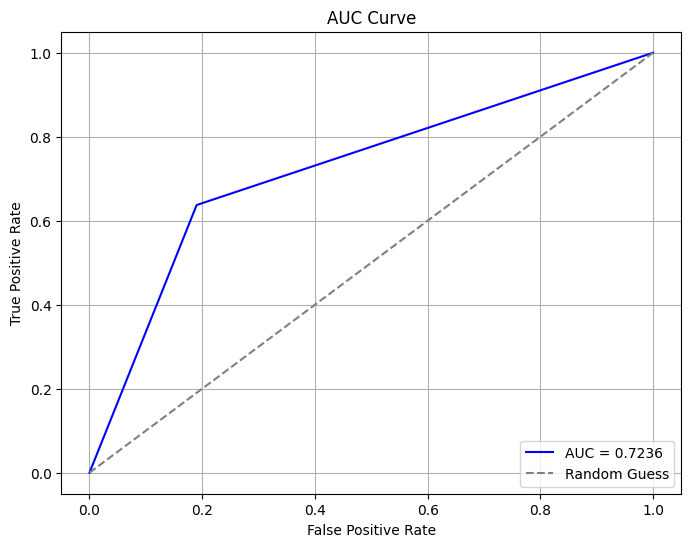

In [10]:
# Calculate FPR and TPR for AUC
fpr, tpr, _ = roc_curve(predictions_df['label'], predictions_df['predicted_label'])
auc = auc(fpr, tpr) if not np.isnan(fpr).any() and not np.isnan(tpr).any() else 0.0

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('../Results/model_3_deep_learning_auc_curve.png')
plt.show()